<a href="https://colab.research.google.com/github/restrepo/articles_COVID-19/blob/master/lens_scotogenic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lens API search for Scotogenic in Lens
* 5,000 API requests and up to 5 million records per month
* 10 API requests/minute and up to 1,000 records per request: `sleep=6`

Check: https://docs.api.lens.org/request.html

Get token: https://www.lens.org/lens/user/subscriptions

Examples: https://github.com/cambialens/lens-api-doc

### Design. 
* The `query` search for exact match of any type: title, abstract, affiliation, etc.
* The `query_terms` search for a list of maximum 20 identifiers
* The `query_ORAND` search for a list of type: title, abstract, full_text  etc, words (phrases) with `match_type=match[_phrase]`. For example `title=['first','second','third']`.
    * By default the OR search is done in title, abstract and full_text search

## Functions and global variables

In [0]:
import getpass
import pandas as pd
import requests
import sys
import time
import os
import datetime
if os.getcwd()=='/content':
    !pip install unidecode
    !mkdir data
import unidecode    

     |████████████████████████████████| 245kB 2.7MB/s 


<!-- #666mmkP9Ibp7bDpLNLKZF8bdYDxCQmxXhFuJzJViVKH92kyBlGmatE2888
 -->

In [0]:
token=getpass.getpass('token:')

token:··········


In [0]:
url = 'https://api.lens.org/scholarly/search'
size=1000

In [0]:
def ORKEYS(key,l,kwargs):
    ll=[ {  kwargs['match_type']:{key: unidecode.unidecode(q)} } for q in l]
    if kwargs['abstract']==True:
        ll=ll+[ {  kwargs['match_type']:{'abstract': unidecode.unidecode(q)} } 
                 for q in l]
        ll=ll+[ {  kwargs['match_type']:{'full_text': unidecode.unidecode(q)} } 
                 for q in l]
    return str(ll).replace("'",'"')

def query_terms(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
      lens_id=list of identifiers
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
    """
    key=list(kwargs.keys())[0]
    l=kwargs[key]
    if isinstance(l,list):
        if len(l)>20:
            print('WARNING: Only first 20 items will be searched')
        ls=str(l).replace("'",'"')
    else:
        sys.exit( 'ERROR: {} must be a list'.format(k) )

    data='''{
    "query": {
        "terms": {
			"%s": %s
		}
     }
    }''' %(key,ls )
    return data

def query(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
     query type must be go first! Example: title, affiliation, abstract, etc:
     For example for `title`:
      title="covid-19" #(or Affiliation o lens_id, or ...) 
      match_type ='match_phrase' #for exact match, or match for OR between words
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
    """
    key=list(kwargs.keys())[0]
    q=unidecode.unidecode(kwargs[key])
    #Set default values
    if not kwargs.get('match_type'):
        kwargs['match_type']='match_phrase'
    if not kwargs.get('size'):
        kwargs['size']=1000
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
           "%s":{
                    "%s": "%s"
               }
           },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(kwargs['match_type'],key,q,
                 kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data


def query_ORAND(**kwargs):
    """
    WARNING: Accents will be removed!
    Use the lens.org API to obtain a API query string
    to feed get_query

    Parameters
    ----------
     query type must be go first! Example: title, affiliation, abstract, etc:
     For example for `title`:
      title="covid-19" #(or Affiliation o lens_id, or ...) 
      match_type ='match_phrase' #for exact match, or match for OR between words
      abstract=bolean. Deafult True. Include query in abstract
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000,
      abstract=True # Search also in abstract 
    """
    key=list(kwargs.keys())[0]
    l=kwargs[key]
    if not isinstance(l,list):
        sys.exit('{} must be a list'.format(key))
    #Set default values
    if not kwargs.get('match_type'):
        kwargs['match_type']='match_phrase'
    if not kwargs.get('size'):
        kwargs['size']=1000
    if kwargs.get('logical')=="AND":
        logical='must'
    else:
        kwargs['logical']="OR"
        logical='should' 
    if not kwargs.get('abstract'):
        if kwargs['logical']=="AND":
            kwargs['abstract']=False
        else:
            kwargs['abstract']=True
    if not kwargs.get('logical'):
        kwargs['logical']="OR"
    if not kwargs.get('range_type'):
        kwargs['range_type']="date_published"
    if not kwargs.get('date_ini'):
        kwargs['date_ini']='1900-01-01'
    if not kwargs.get('date_end'):
        kwargs['date_end']=datetime.datetime.today().strftime('%Y-%m-%d')
    if kwargs.get('range_type')=="year_published":
        date_ini=kwargs.get('date_ini').split('-')[0]
        date_end=kwargs.get('date_end').split('-')[0]
    data='''{
    "query": {
       "bool": {
         "must": [{
            "bool": {
               "%s": %s
                    }
               },
           {
           "range": {
           "%s": {
                    "gte": "%s",
                    "lte": "%s"
                }
           } 
           }
         ]
       }
     },
     "size": %i
    }''' %(logical,
           ORKEYS(key,l,kwargs),
                 kwargs.get('range_type'),
                 kwargs.get('date_ini'),
                 kwargs.get('date_end'),
                 kwargs.get('size'))
    return data


def get_query(*args,**kwargs):
    '''
    Use the lens.org API to obtain a DataFrame with the query

    Parameters
    ----------
      data_function: function to generate the data query. See query(...)
      title="covid-19" #(or Affiliation o lens_id, or ...)
      range_type="date_published",
      date_ini=1900-01-01,
      date_end=... #Default to today
      size=1000, 
      url=API_url,
      token=token #API token  
    '''
    query=args[0]
    token=kwargs.get('token')
    url=kwargs.get('url')
    kk=kwargs.pop('url')
    kk=kwargs.pop('token')
    data=query(**kwargs)
    headers = {'Authorization': '{}'.format(token), 'Content-Type': 'application/json'}
    response = requests.post(url, data=data, headers=headers)
    if response.status_code != requests.codes.ok:
        print(response.status_code)
        r='[]'
    else:
        r=response.text
    return pd.read_json(r)    


In [0]:
RELOAD=True
#https://link.lens.org/eBV1zZsBGQd
querylist=["dark matter","neutrino"]
rr=pd.DataFrame()
start_date=datetime.datetime.strptime('1920-01-01','%Y-%m-%d')
#start_date=datetime.datetime.strptime('2020-03-03','%Y-%m-%d')
today=datetime.datetime.today()
dd=['2014-12-31',today.strftime('%Y-%m-%d')]
#dd=['2020-03-02']
for d in dd:
    if not RELOAD:
        break
    next_date=datetime.datetime.strptime(d,'%Y-%m-%d')
    if next_date.date()==today.date():
        rr.to_json('data/scotogenic_{}.json.gz'.format(
             (start_date-datetime.timedelta(days=1)).strftime('%Y-%m-%d')   ))

    print('{} → {} : '.format( start_date.strftime('%Y-%m-%d'),
                              next_date.strftime('%Y-%m-%d') ),
          end='')
    tmp=get_query(query_ORAND,
      title=querylist,
      logical="AND",
      abstract=False,
      range_type="date_published",
      date_ini=start_date.strftime('%Y-%m-%d'),
      date_end=next_date.strftime('%Y-%m-%d'),
      size=1000,
      url=url,
      token=token) 

    print(tmp.shape)
    rr=rr.append( tmp  ).reset_index(drop=True)
    start_date=next_date+datetime.timedelta(days=1)
    
    #if d==dd[0]:
    #    break   
    time.sleep(7)


1920-01-01 → 2014-12-31 : (923, 3)
2015-01-01 → 2020-04-13 : (809, 3)


### Check results

In [0]:
if RELOAD:
    cv=pd.DataFrame(list(rr.data.values))
    cv.to_json('data/scotogenic.json.gz')
else:
    urljason='https://github.com/restrepo/lensapi/raw/master/data/scotogenic.json.gz'
    cv=pd.read_json(urljason,compression='gzip')

In [0]:
cv.shape

(1732, 29)

In [0]:
cv.scholarly_citations_count.sum()

33586.0

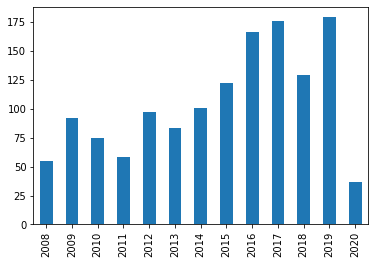

In [0]:
cv['Year']=cv.date_published.apply(lambda s: s.split('-')[0] if type(s)==str else 
                                          s.get('date').split('-')[0] )
cv=cv[~cv['Year'].isna()].reset_index(drop=True)
cv['Year']=cv['Year'].astype(int)
cv[cv['Year']>2007]['Year'].value_counts().sort_index().plot(kind='bar')

### Search for citations

In [0]:
import os
if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Lens.org allows to search for a list of idintifiers ot length until 20

In [0]:
l=list(cv['scholarly_citations'].apply(pd.Series).stack().unique())
len(l)

11575

In [0]:
cvc=pd.DataFrame()
rold=0
terms_max=20
lenl=len(l)
steps=list(range(0,lenl,terms_max))[1:]+[ lenl ]
for r in steps:
    ll=l[rold:r]
    rold=r
    #make lens query
    tmp=get_query(query_terms,lens_id=ll,url=url,token=token)
    cvc=cvc.append(tmp).reset_index(drop=True)
    cvc.to_json('scotogenic_scholarly_citations.json')
    if os.getcwd()=='/content':
        !cp scotogenic_scholarly_citations.json drive/My\ Drive
        
    time.sleep(7)
    #break    

In [0]:
import pandas as pd
cvc=pd.read_json("drive/My Drive/scotogenic_scholarly_citations.json")

In [0]:
dfcvc=pd.DataFrame(list(cvc.data.values))

In [0]:
dfcvc[:14000].to_json('scotogenic_scholarly_citations_part_1.json.gz')
dfcvc[14000:].to_json('scotogenic_scholarly_citations_part_2.json.gz')

In [0]:
ls -lh scotogenic_scholarly_citations_part_*

-rw-r--r-- 1 root root  23M Apr  8 16:45 covid_19_scholarly_citations_part_1.json.gz
-rw-r--r-- 1 root root 8.1M Apr  8 16:45 covid_19_scholarly_citations_part_2.json.gz


In [0]:
dfcvc.columns

Index(['lens_id', 'created', 'open_access', 'publication_type',
       'publication_supplementary_type', 'authors', 'title', 'volume', 'issue',
       'languages', 'references', 'mesh_terms', 'chemicals', 'fields_of_study',
       'funding', 'source_urls', 'abstract', 'year_published',
       'references_count', 'scholarly_citations_count', 'external_ids',
       'start_page', 'end_page', 'source', 'scholarly_citations',
       'author_count', 'date_published', 'keywords', 'patent_citations',
       'patent_citations_count', 'conference', 'clinical_trials'],
      dtype='object')

# Pajek files generation

In [0]:
import pandas as pd
import time
qq=[]
def to_pajek(row,newlist=qq):
    c=len(row.get('scholarly_citations'))
    for i in range(c):
        qq.append({ 'lens_id': row.get('lens_id'),'scholarly_citations': row.get('scholarly_citations')[i] })
    return 'qq is being build'
def to_authors(row,newlist=qq):
    try:
        c=len(row.get('authors'))
    except:
        c=0
    for i in range(c):
        try:
            i_author=row.get('authors')[i]
        except:
            i_author={}
        try:
            i_affiliations=i_author.get('affiliations')[0]
        except:
            i_affiliations={}
        qq.append({ 'lens_id': row.get('lens_id'),
                   'author': '{} {}'.format(i_author.get('first_name'),
                                            i_author.get('last_name')),
                   'affiliation': i_affiliations.get('name'),
                   'country': i_affiliations.get('country_code')})
    return qq#'qq is being build'

In [0]:
base='https://github.com/restrepo/articles_COVID-19/raw/master/data/'
file='scotogenic.json.gz'
cv=pd.read_json('{}{}'.format(base,file),compression='gzip')
time.sleep(2)
file='scotogenic_scholarly_citations.json.gz'
cvc=pd.read_json('{}{}'.format(base,file),compression='gzip')

In [0]:
cvc[cvc.lens_id=='004-766-632-851-036']

,lens_id,created,open_access,publication_type,authors,title,volume,issue,languages,references,fields_of_study,funding,source_urls,abstract,year_published,references_count,scholarly_citations_count,external_ids,start_page,source,scholarly_citations,author_count,date_published,end_page,publication_supplementary_type,patent_citations,patent_citations_count,keywords,mesh_terms,conference,chemicals
7080,004-766-632-851-036,2019-01-15T01:43:41.098000+00:00,"{'locations': {}, 'license': 'cc-by', 'colour'...",journal article,"[{'collective_name': None, 'first_name': 'Juli...",Minimal radiative Dirac neutrino mass models,99,7,[en],"[{'lens_id': '001-740-521-380-003'}, {'lens_id...","[Lepton number, Particle physics, Physics, Dar...","[{'org': 'Consejería de Educación, Universidad...","[{'type': 'pdf', 'url': 'https://arxiv.org/pdf...",Neutrinos may be Dirac particles whose masses ...,2019,58,15.0,"[{'type': 'magid', 'value': '2903617953'}, {'t...",None,"{'title': 'Physical Review D', 'type': 'Journa...","[017-930-819-670-095, 021-281-153-747-005, 030...",4.0,2019-04-09T00:00:00+00:00,None,None,None,NaN,None,None,None,None


In [0]:
cv.sort_values('scholarly_citations_count',ascending=False)

,lens_id,created,open_access,publication_type,authors,title,volume,issue,languages,references,fields_of_study,source_urls,abstract,year_published,references_count,scholarly_citations_count,external_ids,start_page,source,scholarly_citations,author_count,date_published,end_page,funding,publication_supplementary_type,patent_citations,patent_citations_count,mesh_terms,keywords
458,065-989-521-308-04X,2018-05-12T21:00:37.814000+00:00,"{'locations': {}, 'colour': 'green'}",journal article,"[{'collective_name': None, 'first_name': 'Erne...",Verifiable radiative seesaw mechanism of neutr...,73,7,[en],"[{'lens_id': '008-450-256-388-272'}, {'lens_id...","[Neutrino oscillation, Particle physics, Physi...","[{'type': 'html', 'url': 'http://inspirehep.ne...",Neutrino oscillations have established that ne...,2006,14.0,912.0,"[{'type': 'magid', 'value': '2123578256'}, {'t...",077301,"{'title': 'Physical Review D', 'type': 'Journa...","[000-176-214-377-698, 000-403-508-273-162, 000...",1,2006-04-14T00:00:00+00:00,None,None,None,None,NaN,None,None
246,032-623-365-480-871,2018-05-08T22:27:50.181000+00:00,"{'locations': {}, 'colour': 'green'}",journal article,"[{'collective_name': None, 'first_name': 'Scot...",Sterile neutrinos as dark matter,72,1,[en],"[{'lens_id': '001-147-942-052-027'}, {'lens_id...","[Sterile neutrino, Particle physics, Warm dark...","[{'type': 'html', 'url': 'http://cds.cern.ch/r...",The simplest model that can accommodate a viab...,1994,23.0,906.0,"[{'type': 'magid', 'value': '2138874905'}, {'t...",17,"{'title': 'Physical Review Letters', 'type': '...","[000-090-787-660-274, 000-109-171-990-213, 000...",2,1994-01-03T00:00:00+00:00,20,None,None,None,NaN,None,None
727,125-995-698-066-395,2018-05-12T21:03:48.867000+00:00,None,journal article,"[{'collective_name': None, 'first_name': 'Matt...",Constraining warm dark matter candidates inclu...,71,6,[en],"[{'lens_id': '000-510-576-701-943'}, {'lens_id...","[Particle physics, Warm dark matter, Supersymm...","[{'type': 'html', 'url': 'http://www.arxiv-van...",The matter power spectrum at comoving scales o...,2005,56.0,631.0,"[{'type': 'magid', 'value': '2150480596'}, {'t...",063534,"{'title': 'Physical Review D', 'type': 'Journa...","[000-009-327-216-753, 000-066-053-238-322, 000...",5,2005-03-31T00:00:00+00:00,None,None,None,None,NaN,None,None
764,136-907-729-532-579,2018-05-12T16:20:35.295000+00:00,"{'locations': {}, 'license': 'cc-by', 'colour'...",journal article,"[{'collective_name': None, 'first_name': 'Take...","The $\nu$MSM, Dark Matter and Neutrino Masses",631,4,[en],"[{'lens_id': '005-281-525-925-061'}, {'lens_id...","[Sterile neutrino, Particle physics, Physics, ...","[{'type': 'pdf', 'url': 'https://arxiv.org/pdf...",We investigate an extension of the Minimal Sta...,2005,27.0,538.0,"[{'type': 'magid', 'value': '2986640630'}, {'t...",151,"{'title': 'Physics Letters B', 'type': 'Journa...","[000-090-787-660-274, 000-109-171-990-213, 000...",3,2005-03-07T00:00:00+00:00,156,None,[repository],None,NaN,None,None
725,125-627-669-400-789,2018-05-12T21:16:43.812000+00:00,"{'locations': {}, 'colour': 'green'}",journal article,"[{'collective_name': None, 'first_name': 'Xian...",New Dark Matter Candidate: Nonthermal Sterile ...,82,14,[en],"[{'lens_id': '003-264-494-151-229'}, {'lens_id...","[Sterile neutrino, Neutrino oscillation, Lepto...","[{'type': 'pdf', 'url': 'https://arxiv.org/pdf...","Author(s): Shi, Xiangdong; Fuller, George M | ...",1999,21.0,532.0,"[{'type': 'magid', 'value': '2007184284'}, {'t...",2832,"{'title': 'Physical Review Letters', 'type': '...","[000-090-787-660-274, 000-109-171-990-213, 000...",2,1999-04-05T00:00:00+00:00,2835,None,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,192-390-280-503-568,2018-05-16T02:43:28.643000+00:00,None,None,"[{'collective_name': None, 'first_name': 'Robe...",Constraints on sterile neutrino dark matter ca...,None,None,[en],None

In [0]:
qq=[]
#remove articles without citations
cvac=cv.dropna(subset=['scholarly_citations'])
cvac.apply( 
    to_pajek ,axis='columns')

0       qq is being build
2       qq is being build
3       qq is being build
5       qq is being build
8       qq is being build
              ...        
1724    qq is being build
1726    qq is being build
1727    qq is being build
1729    qq is being build
1731    qq is being build
Length: 1146, dtype: object

In [0]:

pcvac=pd.DataFrame(qq)
pcvac.to_excel('scotogenic_pajek_hoja_1.xlsx',index=False)

In [0]:
cvt=cvac.append(cvc).reset_index(drop=True)
cvt=cvt.drop_duplicates('lens_id').reset_index(drop=True)
cvt.shape

(11917, 31)

In [0]:
qq=[]
cvt.apply(to_authors,axis='columns').values

In [0]:
pcvt=pd.DataFrame(qq)
pcvt.to_excel('scotogenic_pajek_hoja_3.xlsx',index=False)

In [0]:
cvt['date']=cvt.created.str.split('T').str[0]
cvt['journal']=cvt.source.apply(lambda d: d.get('title') if isinstance(d,dict) else '')
cvt[['lens_id','title','date','journal']].to_excel('scotogenic_pajek_hoja_2.xlsx',index=False)

# Graphs

In [0]:
import pandas as pd
pd.set_option('display.max_colwidth',200)

In [0]:
df=pd.read_excel('https://docs.google.com/spreadsheets/d/e/2PACX-1vRYwt7RIivFHPvMdvJXegaqXEeECkORVX4i9dHqK6wN2pMvqcPaiGZpwPLS7auWnQ/pub?output=xlsx',
                 sheet_name=1)

In [0]:
gr=df.dropna(subset=['Nodo en el grafo']).reset_index(drop=True)

In [0]:
gr1=gr[gr['Nodo en el grafo'].astype(int).apply(lambda n: n in 
            [29,57,59,63,57,59,67,79,89,90,92,101,107,109,110,114,119,147,152,154,155,160,162,163,164,165,175,
             180])]#[
            #['title','Predictor de importantes último mes','Nodo en el grafo']]

In [0]:
gr1.to_excel('cluster_centro_inferior.xlsx',index=False)

In [0]:
gr[gr['Nodo en el grafo'].astype(int).apply(lambda n: n in 
            [30,75,105,124,141,192,148,133,143])]

,ID,lens_id,SPLC,title,date,journal,Predictor de importantes último mes,Partición,Nodo en el grafo
5,77,032-221-358-108-842,0.0063,Dodelson-Widrow Mechanism in the Presence of Self-Interacting Neutrinos,2020-03-05,Physical Review Letters,0.6300,1,30.0
36,3069,094-690-739-382-440,0.8576,Radiative Scaling Neutrino Mass and Warm Dark Matter,2018-05-15,Physics Letters B,0.8576,0,75.0
39,11775,032-623-365-480-871,0.6506,Sterile neutrinos as dark matter,2018-05-08,Physical Review Letters,0.6506,0,192.0
44,5488,125-627-669-400-789,0.4843,New Dark Matter Candidate: Nonthermal Sterile Neutrinos,2018-05-12,Physical Review Letters,0.4843,0,141.0
47,5344,046-461-192-353-610,0.4483,Constraining the window on sterile neutrinos as warm dark matter,2018-05-12,Monthly Notices of the Royal Astronomical Society,0.4483,0,124.0
69,5490,125-995-698-066-395,0.2592,Constraining warm dark matter candidates including sterile neutrinos and light gravitinos with WMAP and the Lyman-alpha forest,2018-05-12,Physical Review D,0.2592,0,143.0
82,5523,164-503-743-754-236,0.1742,Dark matter sterile neutrinos in stellar collapse: Alteration of energy/lepton number transport and a mechanism for supernova explosion enhancement,2018-05-12,Physical Review D,0.1742,0,148.0
104,5403,075-064-918-781-255,0.0797,Can sterile neutrinos be the dark matter,2018-05-12,Physical Review Letters,0.0797,0,133.0
117,5248,012-623-029-421-017,0.0631,Clustering properties of a sterile neutrino dark matter candidate,2018-05-12,Physical Review D,0.0631,0,105.0


In [0]:
gr[gr['Nodo en el grafo'].astype(int).apply(lambda n: n in 
            [14,47,54,95,161,166,182])]

,ID,lens_id,SPLC,title,date,journal,Predictor de importantes último mes,Partición,Nodo en el grafo
1,39,127-861-135-556-015,0.0076,Neutrino Portal to FIMP Dark Matter with an Early Matter Era,2020-03-23,arXiv: High Energy Physics - Phenomenology,0.7600,1,14.0
95,5571,017-603-650-608-094,0.1031,Neutrino lines from majoron dark matter,2018-05-12,Journal of High Energy Physics,0.1031,0,161.0
96,1435,001-281-578-599-196,0.1018,Neutrino portals to dark matter.,2019-03-30,European Physical Journal C,0.1018,0,47.0
97,5614,043-015-494-896-187,0.1009,New Search for Monochromatic Neutrinos from Dark Matter Decay,2018-05-12,Physical Review D,0.1009,0,166.0
115,1588,059-952-889-220-592,0.0658,Monochromatic dark neutrinos and boosted dark matter in noble liquid direct detection,2019-01-15,Physical Review D,0.0658,0,54.0
152,4515,144-196-164-000-832,0.0255,Prospects for discovering a neutrino line induced by dark matter annihilation,2018-05-13,Journal of Cosmology and Astroparticle Physics,0.0255,0,95.0
191,5703,134-976-134-346-773,0.0106,Dark matter decay to a photon and a neutrino: The double monochromatic smoking gun scenario,2018-05-12,Physical Review D,0.0106,0,182.0


In [0]:
gr[gr['Nodo en el grafo'].astype(int).apply(lambda n: n in 
            [10,34,2,86,87])]

,ID,lens_id,SPLC,title,date,journal,Predictor de importantes último mes,Partición,Nodo en el grafo
18,7,173-160-587-911-248,0.0011,Singlet-doublet fermionic dark matter and gravitational waves in a two-Higgs-doublet extension of the Standard Model,2020-03-27,Physical Review D,0.1100,1,2.0
26,27,042-017-880-325-115,0.0005,Scotogenic dark matter and Dirac neutrinos from unbroken gauged $B-L$ symmetry.,2020-03-23,arXiv: High Energy Physics - Phenomenology,0.0500,1,10.0
27,84,010-030-271-102-085,0.0005,Dark matter stability and Dirac neutrinos using only standard model symmetries,2020-03-05,Physical Review D,0.0500,1,34.0
105,4476,038-981-250-917-605,0.0787,Seesaw roadmap to neutrino mass and dark matter,2018-05-13,Physics Letters B,0.0787,0,86.0
188,4477,039-299-125-527-127,0.0111,"Generalized bottom-tau unification, neutrino oscillations and dark matter: Predictions from a lepton quarticity flavor approach",2018-05-13,Physics Letters B,0.0111,0,87.0


In [0]:
gr[gr['Nodo en el grafo'].astype(int).apply(lambda n: n in 
            [3,5,11,15,21,22,43])]

,ID,lens_id,SPLC,title,date,journal,Predictor de importantes último mes,Partición,Nodo en el grafo
0,40,194-666-813-225-917,0.0081,Light $Z^\prime$ and Dark Matter from U(1)$_X$ Gauge Symmetry.,2020-03-23,arXiv: High Energy Physics - Phenomenology,0.8100,1,15.0
6,60,199-535-702-091-356,0.0061,Boltzmann hierarchies for self-interacting warm dark matter scenarios,2020-03-07,arXiv: Cosmology and Nongalactic Astrophysics,0.6100,1,22.0
9,28,048-650-358-851-085,0.0039,Scotogenic dark matter and single-zero textures of the neutrino mass matrix,2020-03-23,Journal of Physics: Conference Series,0.3900,1,11.0
10,8,071-830-953-469-157,0.0031,"Minimal seesaw extension for neutrino mass and mixing, leptogenesis and dark matter: FIMPzillas through the right-handed neutrino portal",2020-03-23,Journal of Cosmology and Astroparticle Physics,0.3100,1,3.0
11,10,145-907-801-501-272,0.0029,Minimal dark matter models with radiative neutrino masses: From Lagrangians to observables.,2020-03-23,arXiv: High Energy Physics - Phenomenology,0.2900,1,5.0
14,59,145-289-912-938-332,0.0019,A Dark Matter Interpretation of Excesses in Multiple Direct Detection Experiments,2020-03-07,arXiv: High Energy Physics - Phenomenology,0.1900,1,21.0
131,993,059-152-574-334-143,0.0471,Dark matter from freeze-in via the neutrino portal,2019-07-25,European Physical Journal C,0.0471,0,43.0


In [0]:
import pandas as pd
pd.set_option('display.max_colwidth',200)

In [0]:
gr=pd.read_excel('https://docs.google.com/spreadsheets/d/e/2PACX-1vRAxaR-A_Sbr_kYjKoKF9vC6KEqDyjqsHYKKTvhdgwngEsVE7ggd2f-O6dTFsYUYkwHKdMLysTYsC-l/pub?output=xlsx')



Red: Heavy Right handed neutrino dark matter



In [21]:
gr[gr['Nodo'].astype(int).apply(lambda n: n in 
            [9,13,35,38,51,67,72,74,98,103,170,181,165,329,317])]

,Nodo,ID Lens,Título
231,13,147-652-172-053-155,Decaying dark matter at IceCube and its signature on High Energy gamma experiments
237,51,130-711-280-525-025,Neutrinophilic Dark Matter in the epoch of IceCube and Fermi-LAT
238,103,142-673-402-748-640,Probing decaying heavy dark matter with the 4-year IceCube HESE data
246,98,040-314-597-762-326,PeV scale supersymmetry breaking and the IceCube neutrino flux
254,181,118-332-581-216-221,γ-ray Constraints on Decaying Dark Matter and Implications for IceCube
257,170,153-502-466-600-445,Multi-component fermionic dark matter and IceCube PeV scale neutrinos in left-right model with gauge unification
261,165,106-772-205-695-832,High-energy neutrinos from multibody decaying dark matter
262,329,077-049-844-080-700,Heavy right-handed neutrino dark matter and PeV neutrinos at IceCube
268,317,043-015-494-896-187,New Search for Monochromatic Neutrinos from Dark Matter Decay
270,38,000-853-524-359-351,Update on decaying and annihilating heavy dark matter with the 6-year IceCube HESE data


Blue:Direct detection

In [20]:
gr[gr['Nodo'].astype(int).apply(lambda n: n in 
            [26,31,48,50,59,164,204,282,485])]

,Nodo,ID Lens,Título
113,204,009-478-697-750-709,Resonant production of the sterile neutrino dark matter and fine-tunings in the neutrino minimal standard model
155,31,032-084-666-411-386,Neutrino Physics with Dark Matter Detectors
164,59,168-714-230-147-321,How high is the neutrino floor
179,26,144-789-786-046-492,Direct detections of dark matter in the presence of non-standard neutrino interactions
184,50,032-101-221-833-537,Direct detection experiments at the neutrino dipole portal frontier
187,48,129-728-047-909-669,How high is the neutrino floor?
193,164,072-536-477-002-685,Non-standard interactions of solar neutrinos in dark matter experiments
205,282,160-059-384-393-200,Implication of neutrino backgrounds on the reach of next generation dark matter direct detection experiments
207,485,107-543-710-696-091,Solar and Atmospheric Neutrinos: Background Sources for the Direct Dark Matter Searches


Green Sterile neutrinos

In [22]:
gr[gr['Nodo'].astype(int).apply(lambda n: n in 
            [52,73,84,92,96,128,151,157,162,207,137,300,350,409,419,451,460,463])]

,Nodo,ID Lens,Título
290,460,065-994-094-324-120,3.55 keV line in minimal decaying dark matter scenarios
296,128,049-532-687-632-966,Snowmass-2013 Cosmic Frontier 3 (CF3) Working Group Summary: Non-WIMP dark matter
308,52,190-564-713-801-072,N-body simulations of structure formation in thermal inflation cosmologies
312,207,011-322-926-218-945,Dark matter progenitor: Light vector boson decay into sterile neutrinos
318,419,131-545-507-644-850,Constraints on 3.55 keV line emission from stacked observations of dwarf spheroidal galaxies
326,409,069-908-166-039-866,PeV Neutrinos and a 3.5 keV X-Ray Line from a PeV Scale Supersymmetric Neutrino Sector
337,96,141-467-401-884-25X,Cosmological imprints of frozen-in light sterile neutrinos
342,92,165-365-603-952-250,Influence of ∼7 keV sterile neutrino dark matter on the process of reionization
355,350,193-482-587-058-432,Freeze-in production of sterile neutrino dark matter in U(1)B−Lmodel
356,84,066-549-819-056-276,Constraints from Ly-α forests on non-thermal dark matter including resonantly-produced sterile neutrinos


Yellow: Majorana

In [18]:
gr[gr['Nodo'].astype(int).apply(lambda n: n in 
            [30,61,69,126,296,260,293,303])]

,Nodo,ID Lens,Título
412,126,190-807-630-415-807,Non-thermal production of minimal dark matter via right-handed neutrino decay
415,296,009-429-651-646-892,Closing in on minimal dark matter and radiative neutrino masses
420,293,006-529-220-557-061,Radiative Two-Loop Neutrino Masses with Dark Matter
421,69,117-926-160-275-532,Dark side of the seesaw
466,303,018-680-145-951-604,Scale-invariant models with one-loop neutrino mass and dark matter candidates
477,260,076-407-027-747-57X,Leptogenesis and dark matter detection in a TeV scale neutrino mass model with inverted mass hierarchy
501,61,072-141-906-323-545,Scotogenic dark matter and single-zero textures of the neutrino mass matrix
520,30,036-354-152-463-51X,Low scale leptogenesis in a hybrid model of the scotogenic type I and III seesaw models
